## Import

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.unival import UnIVALModel
from PIL import Image

import random
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode

from matplotlib import pyplot as plt

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

In [4]:
# Register refcoco task
tasks.register_task('caption', CaptionTask)

<function fairseq.tasks.register_task.<locals>.register_task_cls(cls)>

### Load model

In [14]:
# Load pretrained ckpt & config

checkpoint_path = '/data/mshukor/logs/ofa/best_models/unival_caption_stage_1/checkpoint_best_test.pt'
video_model_path = '/data/mshukor/logs/ofa/best_models/resnext-101-kinetics.pth'

overrides={"eval_cider":False, "beam":5, "max_len_b":22, "no_repeat_ngram_size":3, "seed":7, "unnormalized": False,
           "bpe_dir":"utils/BPE", "video_model_path": None,}

models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths(checkpoint_path),
        arg_overrides=overrides
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

[autoreload of tasks.ofa_task failed: Traceback (most recent call last):
  File "/data/mshukor/envs/ofa/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/data/mshukor/envs/ofa/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/data/mshukor/envs/ofa/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/data/mshukor/envs/ofa/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/mshukor/unival/tasks/ofa_task.py", line 144, in <module>
    class OFATask(FairseqTask):
  File "/home/mshukor/ofa_ours/fairseq/fairseq/tasks/__init__.py", line 7

self.sample_patch_num 784
self.sample_audio_patch_num None
self.sample_video_patch_num None
self.with_cls False
Loading:  all_resnext101
use bn: <class 'torch.nn.modules.batchnorm.BatchNorm3d'>
unival
getattr(args, "stop_on_max_len", False) False


### Preprocess

In [6]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose(
    [
        lambda image: image.convert("RGB"),
        transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for caption task
def construct_sample(image: Image):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(" what does the image describe?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/data/mshukor/envs/ofa/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  if __name__ == "__main__":
/data/mshukor/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


### Inference

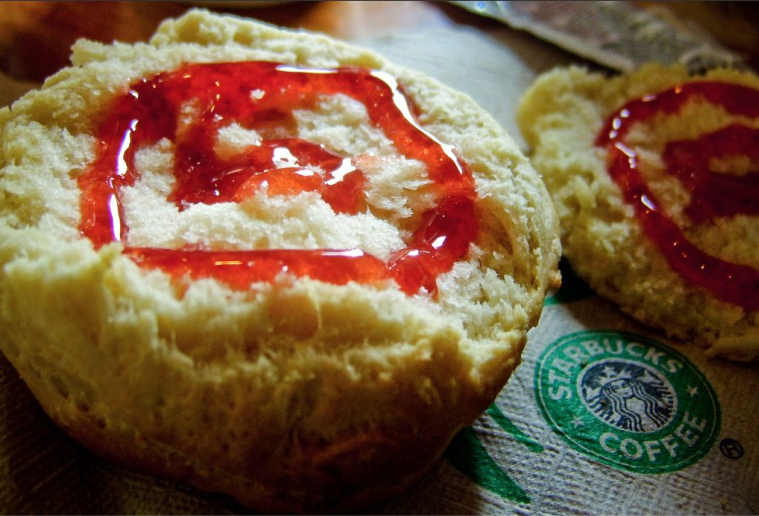

In [11]:
save_dir = '/home/mshukor/ofa_adastra'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002153.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002587.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002532.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002434.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002346.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002164.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002142.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000001960.jpg'
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000001561.jpg'


# Limitations good results
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000010211.jpg'
# img_path = 'results/images/mirror.png'
# img_path = 'results/images/garbage.png'
# img_path = 'results/images/stade.png'
# img_path = 'results/images/gello.png'
# img_path = 'results/images/door.png'
# img_path = 'results/images/bag.png'
# img_path = 'results/images/woman.png'
# img_path = 'results/images/pizza.jpeg'
# img_path = 'results/images/street.jpg'
# img_path = 'results/images/street2.jpg'


# Limitations bad results
# img_path = 'results/images/guitar.png'
img_path = save_dir + '/results/images/muffin.png'
# img_path = save_dir +'/results/images/hydrant.png'



image = Image.open(img_path)
sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
image

In [12]:
from utils.eval_utils import eval_caption

with torch.no_grad():
    result, scores = eval_caption(task, generator, models, sample)

a close up of a doughnut with ketchup on it


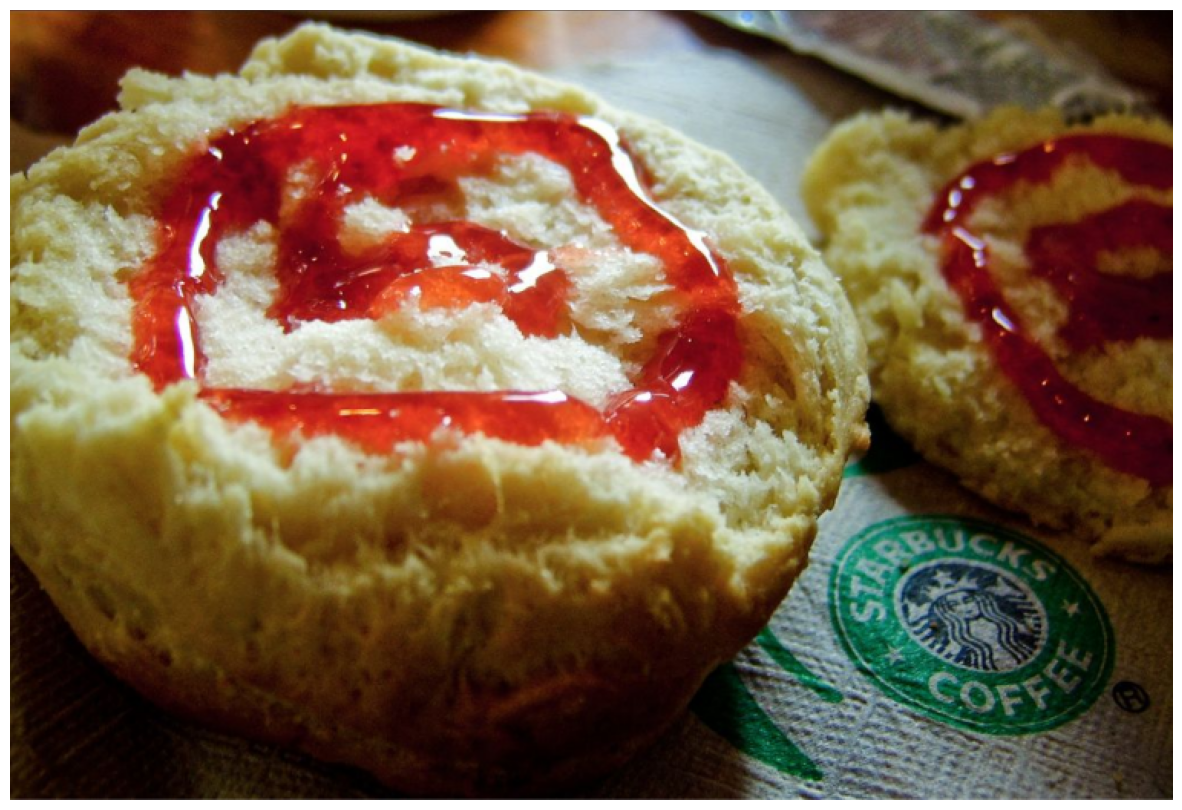

In [13]:
caption = result[0]['caption']
print(caption)
plt.figure(figsize=(15, 15))
plt.axis('off')

plt.imshow(image)

save_path = save_dir+'/results/caption/'+"_".join(caption.split(' '))+".jpg"
plt.savefig(save_path, bbox_inches='tight')


plt.show()

